### CS 109A/STAT 121A/AC 209A/CSCI E-109A 

# Lab 5: Regularization

**Harvard University**<br>
**Fall 2017**<br>
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine**

---

# Table of Contents 

<ol start="0">
<li> Learning Goals </li>
<li> Introduction to regularized regression </li>
<li> Ridge regression with one predictor on a grid</li>
<li> Ridge regression with polynomial features on a grid</li>
<li> Cross-validation </li>
<li> Refitting on full training set </li>
</ol>
**END OF LAB**
<ol start="6">
<li> Feature selection with LASSO regression - good for homework 4!</li>
</ol>

## Part 0: Learning Goals 
In this lab we continue where we left off in Lab 4, with regularized regression.  By the end of this lab, you will be able to:

- Implement ridge and LASSO regression using `sklearn`.
- Interpret the results of ridge and LASSO regression, and compare to the results from simple and multiple linear regression.

*This lab maps on to lectures 7 and 8 and homework 4.*

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

C:\Users\ud354317\AppData\Local\Continuum\Anaconda2\lib\site-packages\seaborn\apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Part 1:  Introduction to regularized regression


Recall from lecture the main idea of regularization.  In the ordinary least squares problem we minimize the loss function 

\begin{equation}
L(\mathbf{\beta}) = \frac{1}{n} \sum_{i = 1}^n |y_i - \mathbf{\beta}^T \mathbf{x}_i|^2,
\end{equation}

to determine regression coefficients $\mathbf{\beta}$.  Here $y_i$ is the response variable for observation $i$, and $\mathbf{x}_i$ is a vector from the predictor matrix  corresponding to observation $i$.



The general idea behind regularization is to penalize the loss function to account for possibly very large values of the coefficients $\mathbf \beta$.  The  aforementioned optimization problem is then adjusted accordingly.  Instead of minimizing $L(\mathbf{\beta})$, we minimize the regularized loss function

\begin{equation}
L_{\mathrm{reg}}(\mathbf{\beta}) = L(\mathbf{\beta}) + \lambda R(\mathbf{\beta}),
\end{equation}

where $R(\mathbf{\beta})$ is a penalty function and $\lambda$ is a scalar that weighs the relative importance of this penalty.  In this lab we will explore two regularized regression models, ridge and LASSO.  In ridge regression, the penalty function is the sum of the squares of the parameters, giving the regularized loss function

\begin{equation}
L_{\mathrm{Ridge}}(\mathbf{\beta}) = \frac{1}{n} \sum_{i = 1}^n |y_i - \mathbf{\beta}^T \mathbf{x}_i|^2 + \lambda \sum_{j = 1}^d \beta_j^2.
\end{equation}

In LASSO regression the penalty function is the sum of the magnitudes of the parameters, leading to

\begin{equation}
L_{\mathrm{LASSO}}(\mathbf{\beta}) = \frac{1}{n} \sum_{i = 1}^n |y_i - \mathbf{\beta}^T \mathbf{x}_i|^2 + \lambda \sum_{j = 1}^d |\beta_j|.
\end{equation}

We will show how these optimization problems can be solved with `sklearn` to determine the model parameters $\mathbf \beta$.  We will also show how to choose $\lambda$ appropriately via cross-validation.

Let's continue working with our data from last time. We load and split the data as in Lab 4. 

In [2]:
df=pd.read_csv("data/noisypopulation.csv")
df.head()

,f,x,y
0,0.047790,0.00,0.011307
1,0.051199,0.01,0.010000
2,0.054799,0.02,0.007237
3,0.058596,0.03,0.000056
4,0.062597,0.04,0.010000


Here `x` and `y` are the predictor and measured response variables, and `f` is the true response.

In [4]:
f = df.f.values
x = df.x.values
y = df.y.values
df.shape

(200, 3)

In [5]:
indexes=np.sort(np.random.choice(x.shape[0], size=60, replace=False))
samplex = x[indexes]
samplef = f[indexes]
sampley = y[indexes]
sample_df=pd.DataFrame(dict(x=x[indexes],f=f[indexes],y=y[indexes]))

In [6]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
f    60 non-null float64
x    60 non-null float64
y    60 non-null float64
dtypes: float64(3)
memory usage: 1.5 KB


In [7]:
sample_df.head()

,f,x,y
0,0.058596,0.03,0.000056
1,0.071233,0.06,0.048360
2,0.128537,0.16,0.083420
3,0.143061,0.18,0.044846
4,0.175324,0.22,0.138297


We split the sample data into training and testing sets.

In [8]:
from sklearn.model_selection import train_test_split
datasize=sample_df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
itrain, itest = train_test_split(np.arange(60),train_size=0.8)
xtrain= sample_df.x[itrain].values
ftrain = sample_df.f[itrain].values
ytrain = sample_df.y[itrain].values
xtest= sample_df.x[itest].values
ftest = sample_df.f[itest].values
ytest = sample_df.y[itest].values

C:\Users\ud354317\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Part 2: Ridge regression with one predictor on a grid

To begin, we'll use `sklearn` to do simple linear regression on the sampled training data.  We'll then do ridge regression with the same data, setting the penalty parameter $\lambda$ to zero.  Setting $\lambda = 0$ reduces the ridge problem to the simple ordinary least squares problem, so we expect the results of these models to be identical.  

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
#build the the ordinary least squares model
simp_reg = LinearRegression()
#fit the model to training data
simp_reg.fit(xtrain.reshape(len(xtrain),1), ytrain)
#save the beta coefficients
beta0_sreg = simp_reg.intercept_
beta1_sreg = simp_reg.coef_[0]
#make predictions everywhere
ypredict = lambda x : beta0_sreg + beta1_sreg*x
print("(beta0, beta1) = (%f, %f)" %(beta0_sreg, beta1_sreg))

(beta0, beta1) = (-0.077298, 1.143408)


We will use the above $\beta$ coefficients as a benchmark for comparision to ridge and LASSO methods.  Let's see that we get the same coefficients with ridge regression.

In [14]:
from sklearn.linear_model import Ridge 

For reference, [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) is the ridge regression documentation.  Notice that the weight $\lambda$ is referred to as `alpha` in the documentation.

The snippet of code below implements the ridge regression with $\lambda = 0$.

In [15]:
#build the ridge regression model with specified lambda, ie, alpha
ridge_reg = Ridge(alpha = 0)
#fit the model to training data
ridge_reg.fit(xtrain.reshape(-1,1), ytrain)  #xtrain.reshape(-1,1) and xtrain.reshape(len(xtrain),1) are equivalent
#save the beta coefficients
beta0_ridge = ridge_reg.intercept_
beta1_ridge = ridge_reg.coef_[0]
#make predictions everywhere
ypredict_ridge = ridge_reg.predict(x.reshape(-1,1))
print("(beta0, beta1) = (%f, %f)" %(beta0_ridge, beta1_ridge))

(beta0, beta1) = (-0.077298, 1.143408)


The beta coefficients for linear and ridge regressions coincide for $\lambda = 0$, as expected. We plot the data and fits.

In [16]:
colors = sns.color_palette()

<IPython.core.display.Javascript object>


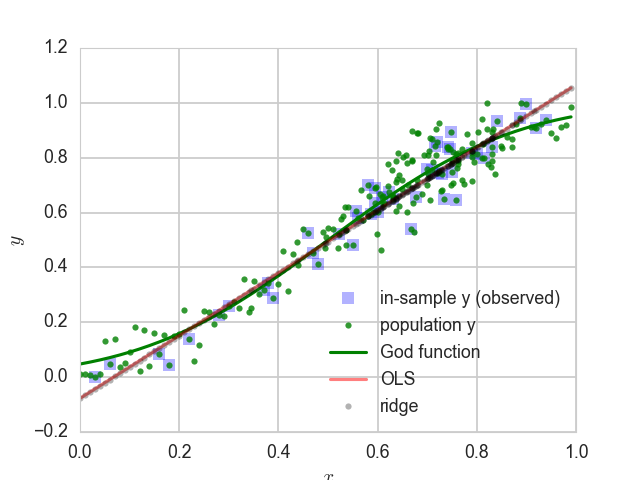

In [23]:
%matplotlib notebook
#plot in-sample training data
plt.plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)")
#plot population data
plt.plot(x, y, '.', alpha=0.8, label="population y");
plt.plot(x, f, color = colors[1], label="God function")
#plot simple linear regression fit
plt.plot(x, ypredict(x), alpha=0.5, label="OLS")
#plot ridge regression fit
plt.plot(x, ypredict_ridge, 'k.', lw = 1, alpha=0.3, label="ridge")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc=4);

> **EXERCISE:** Play around with the values of  $\lambda$ in the ridge regression code.  Increase $\lambda$ from 0 to .01, from 0.01 to 1, from 1 to 5.  What do you observe?  What happens as $\lambda$ goes to $\infty$?  

> **YOUR DISCUSSION HERE:** 

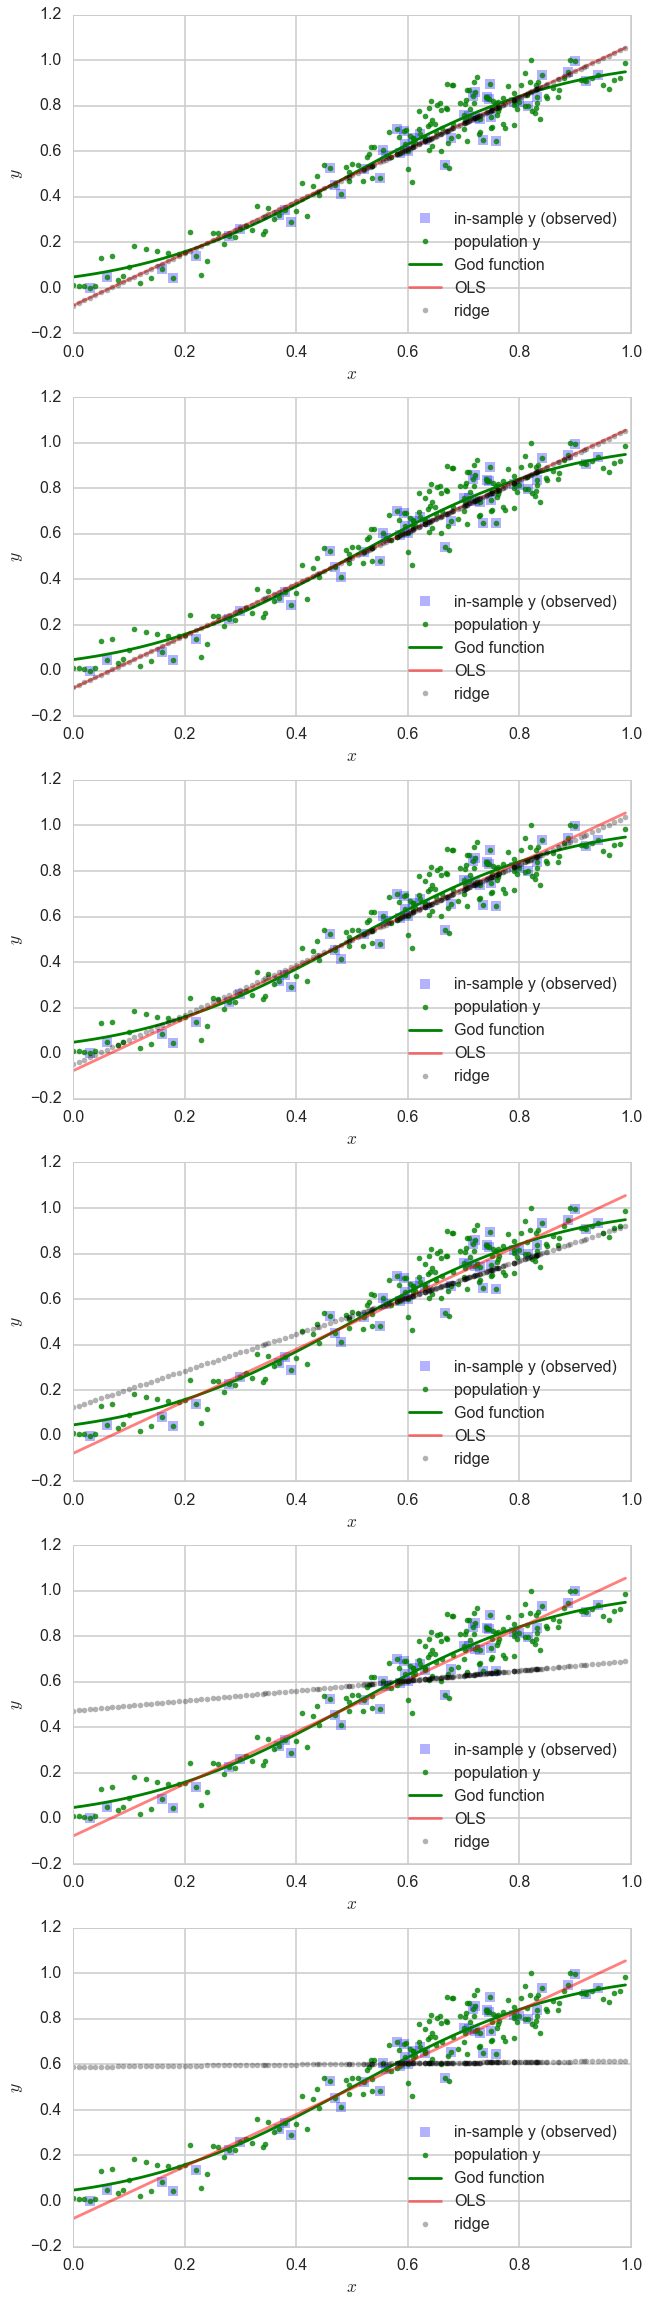

In [51]:
%matplotlib inline
fig, axs = plt.subplots(6,1,figsize=(10, 40))
alpha = [0,0.01,0.1,1,10,100]
for i, lam in enumerate(alpha):
    ridge_reg_alp = Ridge(alpha = lam )
    ridge_reg_alp.fit(xtrain.reshape(-1,1), ytrain)
    beta0_ridge = ridge_reg_alp.intercept_
    beta1_ridge = ridge_reg_alp.coef_[0]
    ypredict_ridge_alp = ridge_reg_alp.predict(x.reshape(-1,1))
    #print("(beta0, beta1) = (%f, %f)" %(beta0_ridge, beta1_ridge))
    axs[i].plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)")
    axs[i].plot(x, y, '.', alpha=0.8, label="population y");
    axs[i].plot(x, f, color = colors[1], label="God function")
    axs[i].plot(x, ypredict(x), alpha=0.5, label="OLS")
    axs[i].plot(x, ypredict_ridge_alp, 'k.', lw = 1, alpha=0.3, label="ridge")
    axs[i].set_xlabel('$x$')
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc=4)
    

## Part 3: Ridge regression with polynomial features on a grid

Now we'll make a more complex model by adding polynomial features.  Instead of building the linear model $y = \beta_0 + \beta_1 x$, we build a polynomial model $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \ldots \beta_d x^d$ for some $d$ to be determined (see Lab 4 for details on choosing hyper-parameter $d$).  This regression will be linear though, since we'll be treating  $x^2, \ldots, x^d$ themselves as predictors in the linear model.  We did this in Lab 4 but it's worth a review.  

We map $x$ to $1, x, x^2, \ldots, x^d$, and then build a linear regression model on this linear function of polynomial features.  To do this, we use `sklearn` to build what is known as the *Vandermonde* matrix, the generalizaiton of the predictor matrix $X$ discussed in Lab 3. For example, if we have three observations

\begin{equation*}\begin{pmatrix}
x_1 \\
x_2 \\
x_3\\
\end{pmatrix}, \end{equation*}

and we want  polynomial features up to and including degree 4, we build the predictor matrix

\begin{equation*}\begin{pmatrix}
x_1 \\
x_2 \\
x_3 \\
\end{pmatrix} \rightarrow X = \begin{bmatrix}
x_1^0 & x_1^1 & x_1^2 & x_1^3 & x_1^4\\
x_2^0 & x_2^1 & x_2^2 & x_2^3 & x_2^4\\
x_3^0 & x_3^1 & x_3^2 & x_3^3 & x_3^4\\
\end{bmatrix} = 
\begin{bmatrix}
1& x_1^1 & x_1^2 & x_1^3 & x_1^4\\
1 & x_2^1 & x_2^2 & x_2^3 & x_2^4\\
1 & x_3^1 & x_3^2 & x_3^3 & x_3^4\\
\end{bmatrix}.
\end{equation*}

In [52]:
from sklearn.preprocessing import PolynomialFeatures

> **EXERCISE: ** Before we continue working with the data, make a toy vector called `toy`, where  

>\begin{equation}
\mathrm{toy} = \begin{pmatrix}
0 \\
2 \\
5 \\
\end{pmatrix}
. 
\end{equation}
> Build the feature matrix up to (and including) degree 4. Confirm that the entries in the matrix are what you'd expect based on the above discussion.

In [53]:
# your code here
PolynomialFeatures(4).fit_transform(np.array([0, 2, 5]).reshape(-1,1))

array([[   1.,    0.,    0.,    0.,    0.],
       [   1.,    2.,    4.,    8.,   16.],
       [   1.,    5.,   25.,  125.,  625.]])

We now continue working with our data.  We write a function to make polynomial features of given degrees as we did in Lab 4, and we store the features in a dictionary. 

In [54]:
def make_features(train_set, test_set, degrees):
    train_dict = {}
    test_dict = {}
    for d in degrees:
        traintestdict={}
        train_dict[d] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        test_dict[d] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
    return train_dict, test_dict

> **EXERCISE: ** Fill in the code below to perform ridge regression on the training data for the given set of $\lambda$.  Then predict on the grid and store the results in  `ypredict_ridge`.

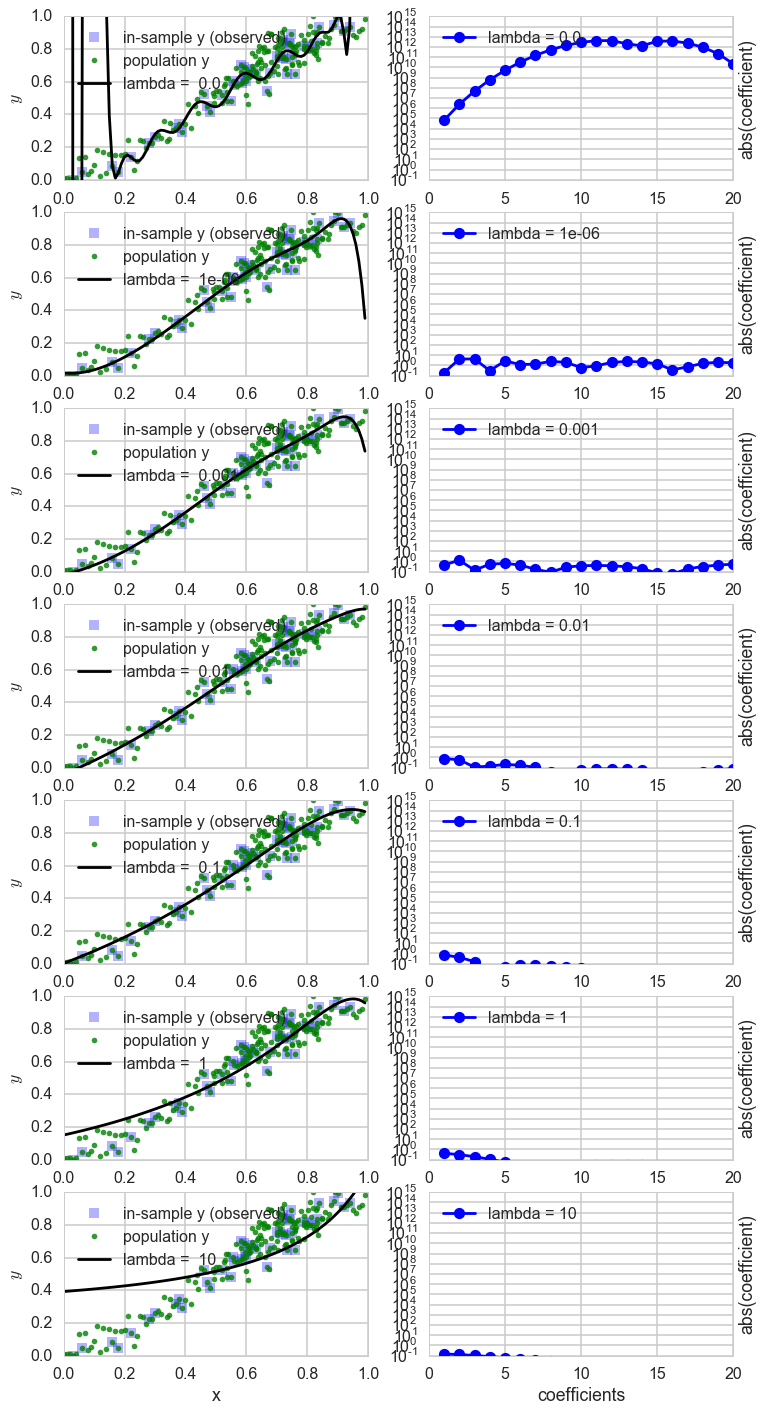

In [55]:
d = 20
rows = 7
cols = 2
lambdas = [0., 1e-6, 1e-3, 1e-2, 1e-1, 1, 10]
grid_to_predict = np.arange(0, 1, .01)
train_dict, grid_dict = make_features(xtrain, grid_to_predict, range(0,d + 1))

fig, axs = plt.subplots(rows, cols, figsize=(12, 24))
axs = axs.ravel()
Xtrain = train_dict[d]

for i, lam in enumerate(lambdas):
    #your code here
    ridge_reg = Ridge(alpha = lam)
    ridge_reg.fit(Xtrain, ytrain)
    ypredict_ridge = ridge_reg.predict(grid_dict[d])
    #code provided from here on
    left = 2*i
    right = 2*i + 1
    axs[left].plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)")
    axs[left].plot(x, y, '.', alpha=0.8, label="population y")
    axs[left].plot(grid_to_predict, ypredict_ridge, 'k-', label="lambda =  %s" % str(lam))
    axs[left].set_ylabel('$y$')
    axs[left].set_ylim((0, 1))
    axs[left].set_xlim((0, 1))
    axs[left].legend(loc=2)
    coef = ridge_reg.coef_.ravel()
    axs[right].semilogy(np.abs(coef), marker='o', label="lambda = %s" % str(lam))
    axs[right].set_ylim((1e-1, 1e15))
    axs[right].yaxis.set_label_position("right")
    axs[right].set_ylabel('abs(coefficient)')
    axs[right].legend(loc='upper left')
axs[2*(rows-1)].set_xlabel("x")
axs[2*(rows-1) + 1].set_xlabel("coefficients");



As you can see, as we increase $\lambda$ from 0 to 1, we start out overfitting, then doing well, and then our fits develop a mind of their own irrespective of data, as the penalty term dominates.

> **EXERCISE:** What would you expect if you compared a performance metric between these models on a grid?

> **YOUR DISCUSSION HERE:** 

## Part 4: Cross-validation

Let's use cross-validation to determine the critical value of $\lambda$, which we'll refer to as $\lambda^*$. To do this we use the concept of a *meta-estimator* from scikit-learn.  As the API paper from Lab 4 explains:

>In scikit-learn, model selection is supported in two distinct meta-estimators, GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    est = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier=GridSearchCV(est, param_grid=parameters, cv=4, scoring="neg_mean_squared_error")
    
The `GridSearchCV` replaces the manual iteration over the folds using `KFolds` and the averaging we did in Lab 4, doing it all for us. It takes a hyper-parameter grid in the shape of a dictionary as input, and sets $\lambda$ to the values you want to try, one by one. It then trains the model using cross-validation, and gets the error for each value of the hyper-parameter $\lambda$. Finally it compares the errors for the different $\lambda$'s, and picks the best choice model.

In [56]:
from sklearn.model_selection import GridSearchCV
def cv_optimize_ridge(x, y, list_of_lambdas, n_folds=4):
    est = Ridge()
    parameters = {'alpha': list_of_lambdas}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(est, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error")
    gs.fit(x, y)
    return gs

> **EXERCISE:** Use the function above to fit the model on the training set with 4-fold cross validation.  Save the fit as the variable `fitmodel`.

In [57]:
# your code here
lambda_list = [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
fitmodel = cv_optimize_ridge(Xtrain, ytrain, lambda_list, n_folds=4)

In [58]:
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_

(Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 {'alpha': 0.01},
 -0.0039626887169264676)

We also output the mean cross-validation error at different $\lambda$ (with a negative sign, as scikit-learn likes to maximize negative error which is equivalent to minimizing error).

In [59]:
fitmodel.cv_results_

{'mean_fit_time': array([ 0.00550008,  0.00075006,  0.00124991,  0.00099999,  0.00099999,
         0.00225002,  0.00125003,  0.00099999,  0.00174999,  0.00100011,
         0.00124991]),
 'mean_score_time': array([ 0.00024998,  0.00024998,  0.00025004,  0.00050002,  0.00075001,
         0.        ,  0.00024998,  0.00049996,  0.00050002,  0.00024998,
         0.00049996]),
 'mean_test_score': array([-0.00704967, -0.00539684, -0.00453781, -0.00419093, -0.00409988,
        -0.00400052, -0.00400267, -0.00396269, -0.00413625, -0.0089876 ,
        -0.03146986]),
 'mean_train_score': array([-0.0031963 , -0.00322382, -0.00324503, -0.00325673, -0.00326205,
        -0.00329598, -0.0033344 , -0.00350517, -0.00393303, -0.00814164,
        -0.02839638]),
 'param_alpha': masked_array(data = [1e-08 1e-06 1e-05 5e-05 0.0001 0.0005 0.001 0.01 0.1 1.0 10.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': [{'alpha': 1e-08},
  {

In [62]:
fit_lambdas = [d['alpha'] for d in fitmodel.cv_results_['params']]
fit_scores = fitmodel.cv_results_['mean_test_score']

> **EXERCISE:** Plot log10-log10 plot of `-fit_scores` versus `fit_lambdas`.

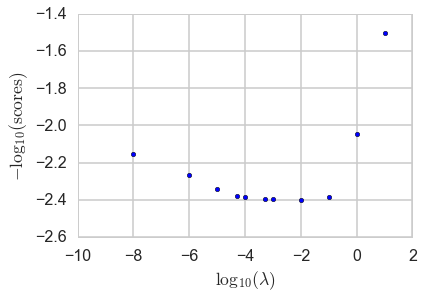

In [63]:
#your code here
plt.scatter(np.log10(fit_lambdas), np.log10(-fit_scores))
plt.xlabel('$\log_{10}(\lambda)$')
plt.ylabel('$-\log_{10}(\mathrm{scores})$')


## Part 5: Refitting on full training set

We now refit the estimator on the training set, and calculate and plot the test set error and the polynomial coefficients. Notice how many of these coefficients have been pushed to lower values or 0.


> **EXERCISE:** Assign to variable `est` the classifier obtained by fitting the entire training set using the best $\lambda$ found above.  Assign the predictions to the variable `ypredict_ridge_best`.

In [70]:
# your code here
lambdawechoose = fitmodel.best_params_['alpha']
est = Ridge(alpha=lambdawechoose).fit(Xtrain,ytrain)
d = 20
ypredict_ridge_best = est.predict(grid_dict[d])

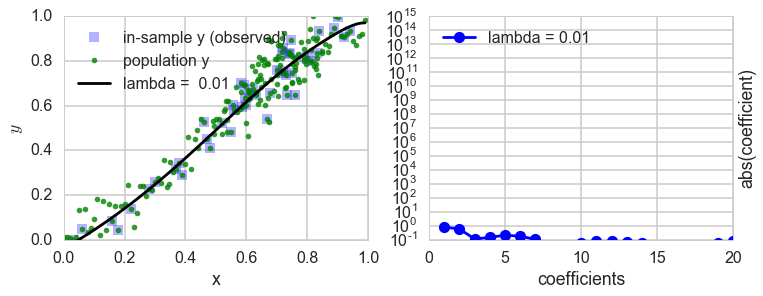

In [71]:
#code provided from here on
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
left = 0
right = 1
axs[left].plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)")
axs[left].plot(x, y, '.', alpha=0.8, label="population y")
axs[left].plot(grid_to_predict, ypredict_ridge_best, 'k-', label="lambda =  %s" % str(lambdawechoose))
axs[left].set_ylabel('$y$')
axs[left].set_ylim((0, 1))
axs[left].set_xlim((0, 1))
axs[left].legend(loc=2)
coef = est.coef_.ravel()
axs[right].semilogy(np.abs(coef), marker='o', label="lambda = %s" % str(lambdawechoose))
axs[right].set_ylim((1e-1, 1e15))
axs[right].yaxis.set_label_position("right")
axs[right].set_ylabel('abs(coefficient)')
axs[right].legend(loc='upper left')
axs[left].set_xlabel("x")
axs[right].set_xlabel("coefficients");

# END OF LAB 

## Part 6: Feature selection with LASSO regression 
Below is a completely worked example of feature selection with LASSO, which will be helpful for homework 4.  For reference [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) is the documentation for LASSO.

In [72]:
from sklearn.linear_model import Lasso
#function to do lasso with cross validation
def cv_optimize_lasso(X, y, list_of_lambdas, n_folds=4):
    #build the lasso model
    clf = Lasso()
    parameters = {"alpha": list_of_lambdas}
    #the scoring parameter below is the default one in ridge, but you can use a 
    #different one in the cross-validation phase if desired.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error")
    gs.fit(X, y)
    return gs

In [73]:
#List of Lambda (lol!) values
lol = [1e-8,1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
#fit lasso model to training data with cross-validation
fitmodel_lasso = cv_optimize_lasso(Xtrain, ytrain, lol, n_folds=4)

C:\Users\ud354317\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [74]:
#choose the optimal lambda
lambdawechoose_lasso = fitmodel_lasso.best_params_['alpha']
#estimate with this optimal lambda
est_lasso = Lasso(alpha=lambdawechoose_lasso).fit(Xtrain,ytrain)
est_lasso

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [75]:
#function that pulls out the important features
def nonzero_lasso(est, lcols):
    featuremask=(est.coef_ !=0.0)
    return pd.DataFrame(dict(feature=lcols, coef=est.coef_, 
        abscoef=np.abs(est.coef_)))[featuremask].sort_values('abscoef', 
                                                    ascending=False)

In [76]:
#x^1, x^2, x^6, x^20 are the important features
lasso_importances=nonzero_lasso(est_lasso, list(range(d+1)))
lasso_importances.set_index("feature", inplace=True)
lasso_importances

,abscoef,coef
feature,,
1,1.123221,1.123221


In [77]:
#function that pulls out the trivial features
def zero_lasso(est, lcols):
    featuremask=(est.coef_ ==0.0)
    return pd.DataFrame(dict(feature=lcols, coef=est.coef_, 
        abscoef=np.abs(est.coef_)))[featuremask].sort_values('abscoef', 
                                                    ascending=False)

In [78]:
#calculate and print the trivial features.  
lasso_zeros=zero_lasso(est_lasso, list(range(d+1)))
lasso_zeros.set_index("feature", inplace=True)
lasso_zeros

,abscoef,coef
feature,,
0,0.0,0.0
2,0.0,0.0
19,0.0,-0.0
18,0.0,-0.0
17,0.0,-0.0
16,0.0,-0.0
15,0.0,-0.0
14,0.0,-0.0
13,0.0,-0.0


In [79]:
#17 of the 21 features are trivial, 4 are important
len(lasso_zeros), len(lasso_importances)

(20, 1)